In [3]:
import chess 
import torch, torch.nn as nn, torch.nn.functional as F 
import random
from collections import deque

# let's write board2input 
# Create a chess board in a random configuration
board = chess.Board()
board_history = deque(maxlen=8)

# Make 10-20 random legal moves
num_moves = random.randint(10, 20)
for _ in range(num_moves):
    board_history.append(board.copy())
    legal_moves = list(board.legal_moves)
    if not legal_moves:  # Game ended
        break
    move = random.choice(legal_moves)
    board.push(move)

print(f"Board after {board.fullmove_number} moves:")
print(board)


Board after 10 moves:
r n b . k b n .
. p . p . p . r
. . . . . . q p
p . p . N . p .
P . P . . . P .
. . . . . . . .
. P . P P P . P
R N B Q K B R .


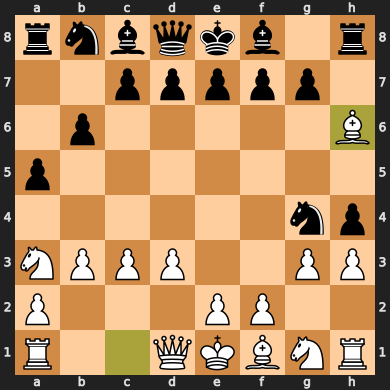

In [7]:
def get_template(): 
    # map 
    return 

In [ ]:
# let's now get 12 boards, 1 for each type of piece for each layer, and stack them
from typing import List 

TYPES = [chess.PAWN, chess.ROOK, chess.KING,
            chess.QUEEN, chess.BISHOP, chess.KNIGHT]
TYPE_TO_IDX  = {t:i for i,t in enumerate(TYPES)}
COLOR_TO_IDX = {chess.BLACK:0, chess.WHITE:1}

def board2input(board_history: List[chess.Board]) -> torch.Tensor: # chess.Board -> [MT+ L, 8, 8] input     
    M = len(board_history)
    T = len(TYPES)*2 + 2       # 12 piece‐planes + 2 repetition‐flags
    L = 7                             # turn, ply/1000, castling×4, halfmove/50
    mtl = M*T + L

    out = torch.zeros(mtl, 8, 8, dtype=torch.float32)

    # M * T channels
    for i, board in enumerate(board_history): 
        board_offset = T*i # eg. board 4 means we start indexing ch at 24
        for (pos, piece) in board.piece_map().items(): 
            # map piece to a (ch, r, c)
            t = TYPE_TO_IDX[piece.piece_type]
            c = COLOR_TO_IDX[piece.color]
            piece_offset = t*2 + c # every type channel has two slots, one for each player
            ch = board_offset + piece_offset
            row, col = divmod(pos, 8)
            out[ch, row, col] = 1.

        # hardcode repetition flag channels
        out[board_offset, :, :] = board.is_repetition(2)
        board_offset+=1
        out[board_offset, :, :] = board.is_repetition(4)

    # L channels for special things 
    last = board_history[-1]
    out[board_offset+1, :, :].fill_(int(last.turn))
    out[board_offset+2, :, :].fill_(last.ply()/1000.0)
    out[board_offset+3, :, :].fill_(last.has_kingside_castling_rights(last.turn))
    out[board_offset+4, :, :].fill_(last.has_queenside_castling_rights(last.turn))
    out[board_offset+5, :, :].fill_(last.has_kingside_castling_rights(not last.turn))
    out[board_offset+6, :, :].fill_(last.has_queenside_castling_rights(not last.turn))
    # game is draw is pawns dont move for 50 moves 
    out[board_offset+7, :, :].fill_(last.halfmove_clock / 50.0)

    return out 

b, mtl = 1, 119 

# board2input took 1.13 ms (min)
# board2input took 1.16 ms (avg)
# board2input took 2.94 ms (max)

input = board2input(board_history)

# need to fix fwd of model w/ logit masking after this 
# then write MCTS shell with eg. random selection and check things work 
    # before diving into mcts implementation 

Input shape: torch.Size([119, 8, 8])
board2input took 1.13 ms (min)
board2input took 1.16 ms (avg)
board2input took 2.94 ms (max)


tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [49]:
list(board.legal_moves)[0].uci()
# /4672

'e5f7'

In [ ]:
# The first 56 planes encode
# possible ‘queen moves’ for any piece: a number of squares [1..7] in which the piece will be
# moved, along one of eight relative compass directions {N,NE,E,SE,S,SW,W,NW} * len

# output in 0-72 template planes 
def template_id(dx: int, dy: int, promo: chess.Promotion) -> int: 
    # return a dict of 73, 56 queen-like, 8 knight, 9 promo 

    # underpromotion cases
    # Knights (64-66), Bishops (67-69), Rooks (70-72)
    # For pawn promotions, we need to check if it's a promotion move and what piece it becomes
    if promo is not None:
        # Get the base index for the promotion type (knight=64, bishop=67, rook=70)
        if promo == chess.KNIGHT:
            base_idx = 64
        elif promo == chess.BISHOP:
            base_idx = 67
        elif promo == chess.ROOK:
            base_idx = 70
        else:  # QUEEN promotions are handled by the normal move encoding
            return template_id(dx, dy, None)
            
        # Determine which diagonal: 0 for file-1, 1 for file+1, 2 for straight ahead
        if dx == 1 and abs(dy) == 1:  # Diagonal capture
            diagonal_type = 0 if dy == -1 else 1  # Left or right diagonal
        elif dx == 1 and dy == 0:  # Straight ahead
            diagonal_type = 2
        else:
            # Unexpected promotion move
            raise Exception('Template ID error, unexpected promotion move...')
        return base_idx + diagonal_type
    
    # queen-like is directions * len 
    elif abs(dx) == abs(dy): # eg. [3, -3] is SE so entry 3 in list above, and len 3 so k = 8 * len + entry = 27 in 0, ..., 72
        # Determine direction (0-7) for diagonal moves
        direction = 0
        if dx > 0 and dy > 0:
            direction = 1  # NE
        elif dx > 0 and dy < 0:
            direction = 3  # SE
        elif dx < 0 and dy < 0:
            direction = 5  # SW
        elif dx < 0 and dy > 0:
            direction = 7  # NW
            
        length = abs(dx)
        return direction * 7 + (length - 1)
    elif (dx == 0 and abs(dy) > 0) or (dy == 0 and abs(dx) > 0): 
        # Determine direction (0-7) for orthogonal moves
        direction = 0
        if dx == 0 and dy > 0:
            direction = 0  # N
        elif dx > 0 and dy == 0:
            direction = 2  # E
        elif dx == 0 and dy < 0:
            direction = 4  # S
        elif dx < 0 and dy == 0:
            direction = 6  # W
            
        length = max(abs(dx), abs(dy))
        return direction * 7 + (length - 1)
    # knight-like moves
    elif (abs(dx) == 1 and abs(dy) == 2) or (abs(dx) == 2 and abs(dy) == 1): 
        # Knight moves are indexed from 56 to 63 (8 possible knight moves)
        # Map each knight move pattern to a specific index in that range
        if dx == 1 and dy == 2:
            return 56  # Knight NNE
        elif dx == 2 and dy == 1:
            return 57  # Knight ENE
        elif dx == 2 and dy == -1:
            return 58  # Knight ESE
        elif dx == 1 and dy == -2:
            return 59  # Knight SSE
        elif dx == -1 and dy == -2:
            return 60  # Knight SSW
        elif dx == -2 and dy == -1:
            return 61  # Knight WSW
        elif dx == -2 and dy == 1:
            return 62  # Knight WNW
        elif dx == -1 and dy == 2:
            return 63  # Knight NNW
    

    
# takes eg. "b5e7" -> idx 2373 out of 4672 in action idx 
def move2index(board: chess.Board, move: chess.Move) -> int: 
    from_sq, to_sq = move.from_square, move.to_square
    
    # invert if black bc this should always be from player's pov
    if board.turn == chess.BLACK: 
        from_sq, to_sq = 63 - from_sq, 63 - to_sq
    
    from_rank, to_rank = from_sq//8, to_sq//8
    from_file, to_file = from_sq % 8, to_sq % 8
    # get dx, dy
    dx, dy = to_rank - from_rank, to_file - from_file
    # get channel (template id)
    k = template_id(dx, dy, move.promotion)
    
    return 64 * k + from_sq


# takes a board to possible next moves that are legal out of [4672] moves
def legal_mask(logits: torch.Tensor, board: chess.Board, nactions: int = 4672) -> torch.Tensor: 
    # 1, nactions
    mask = torch.zeros(nactions, dtype=torch.bool)
    for mv in board.legal_moves: 
        idx = move2index(board, mv)    
        mask[idx] = True

    return logits.masked_fill(~mask, float('-inf'))
    


